In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint

In [22]:
df_app_meta = pd.read_csv('data/application_metadata.csv')

df_demographics = pd.read_csv('data/demographics.csv')

# pip install pandas openpyxl
df_loan = pd.read_excel('data/loan_details.xlsx')

# pip install pandas pyarrow
# pip install pandas fastparquet
df_credit = pd.read_parquet('data/credit_history.parquet')

df_finance = pd.read_json('data/financial_ratios.jsonl', lines=True)

# pip install lxml
df_geo = pd.read_xml("data/geographic_data.xml")


df_metadata_demographics = pd.merge(df_app_meta, df_demographics, left_on='customer_ref', right_on='cust_id')
df_loan_metadata_demographics = pd.merge(df_loan, df_metadata_demographics, left_on='customer_id', right_on='customer_ref')

df_finance_credit_hist = pd.merge(df_finance, df_credit, left_on='cust_num', right_on='customer_number')
df_finance_credit_hist_geo = pd.merge(df_finance_credit_hist, df_geo, left_on='cust_num', right_on='id')

df = pd.merge(df_loan_metadata_demographics, df_finance_credit_hist_geo, left_on='customer_id', right_on='cust_num')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89999 entries, 0 to 89998
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 89999 non-null  int64  
 1   loan_type                   89999 non-null  object 
 2   loan_amount                 89999 non-null  object 
 3   loan_term                   89999 non-null  int64  
 4   interest_rate               89999 non-null  float64
 5   loan_purpose                89999 non-null  object 
 6   loan_to_value_ratio         89999 non-null  float64
 7   origination_channel         89999 non-null  object 
 8   loan_officer_id             89999 non-null  int64  
 9   marketing_campaign          89999 non-null  object 
 10  customer_ref                89999 non-null  int64  
 11  application_id              89999 non-null  int64  
 12  application_hour            89999 non-null  int64  
 13  application_day_of_week     899

In [23]:
df.to_csv('data/merged_data.csv', index=False)

In [24]:
df['default'].value_counts()

default
0    85405
1     4594
Name: count, dtype: int64

In [25]:
columns = ['customer_id','loan_officer_id', 'customer_ref', 'application_id',
           'cust_id', 'cust_num', 'customer_number', 'id', 'previous_zip_code']

df.drop(columns, axis=1, inplace=True)

In [26]:
cols_to_clean = [
    'loan_amount', 'annual_income', 'monthly_income', 'existing_monthly_debt',
    'monthly_payment', 'revolving_balance', 'credit_usage_amount',
    'available_credit', 'total_monthly_debt_payment', 'total_debt_amount',
    'monthly_free_cash_flow'
]

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(r'[$,\s()]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df[cols_to_clean].isnull().sum())
print("-" * 30)
print(df[cols_to_clean].dtypes)

loan_amount                      0
annual_income                    0
monthly_income                   0
existing_monthly_debt            0
monthly_payment                  0
revolving_balance             1377
credit_usage_amount              0
available_credit                 0
total_monthly_debt_payment       0
total_debt_amount                0
monthly_free_cash_flow           0
dtype: int64
------------------------------
loan_amount                     int64
annual_income                   int64
monthly_income                float64
existing_monthly_debt         float64
monthly_payment               float64
revolving_balance             float64
credit_usage_amount           float64
available_credit              float64
total_monthly_debt_payment    float64
total_debt_amount             float64
monthly_free_cash_flow        float64
dtype: object


In [27]:
median_emp_length = df['employment_length'].median()
median_revolving_balance = df['revolving_balance'].median()
median_delinquencies = df['num_delinquencies_2yrs'].median()

In [28]:
df['employment_length'] = df['employment_length'].fillna(median_emp_length)
df['revolving_balance'] = df['revolving_balance'].fillna(median_revolving_balance)
df['num_delinquencies_2yrs'] = df['num_delinquencies_2yrs'].fillna(median_delinquencies)

In [29]:
df['new_loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
df['new_monthly_payment_ratio'] = df['monthly_payment'] / df['monthly_income']
df['cash_flow_to_income_ratio'] = df['monthly_free_cash_flow'] / df['monthly_income']

In [30]:
df.select_dtypes(include='object').nunique()

loan_type                12
loan_purpose              8
origination_channel       4
marketing_campaign       26
preferred_contact         3
referral_code          7805
account_status_code       5
employment_type          16
education                 5
marital_status            3
state                    20
dtype: int64

In [31]:
df.drop(columns=['referral_code'], inplace=True)
print("Dropped 'referral_code' due to high cardinality.")

Dropped 'referral_code' due to high cardinality.


In [32]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    print('\n', col, " Unique values")
    print(df[col].unique())



 loan_type  Unique values
['Personal' 'mortgage' 'Personal Loan' 'PERSONAL' 'CreditCard'
 'Credit Card' 'Mortgage' 'Home Loan' 'MORTGAGE' 'CC' 'credit card'
 'personal']

 loan_purpose  Unique values
['Debt Consolidation' 'Refinance' 'Major Purchase' 'Medical'
 'Revolving Credit' 'Home Improvement' 'Home Purchase' 'Other']

 origination_channel  Unique values
['Direct Mail' 'Branch' 'Online' 'Broker']

 marketing_campaign  Unique values
['W' 'B' 'K' 'A' 'S' 'Q' 'J' 'U' 'I' 'T' 'E' 'Z' 'O' 'F' 'M' 'H' 'R' 'G'
 'D' 'Y' 'V' 'X' 'C' 'P' 'N' 'L']

 preferred_contact  Unique values
['Mail' 'Phone' 'Email']

 account_status_code  Unique values
['ACT-2' 'ACT-3' 'A01' 'ACT-1' 'ACTIVE']

 employment_type  Unique values
['Full-time' 'FULL_TIME' 'Full Time' 'Fulltime' 'Part Time'
 'Self Employed' 'FT' 'Self Emp' 'Contractor' 'Self-employed'
 'SELF_EMPLOYED' 'Contract' 'PART_TIME' 'CONTRACT' 'PT' 'Part-time']

 education  Unique values
['Graduate' 'High School' 'Bachelor' 'Some College' 'Advanced'

In [ ]:
loan_type_map = {
    'Personal': 'Personal', 'Personal Loan': 'Personal', 'PERSONAL': 'Personal', 'personal': 'Personal',
    'mortgage': 'Mortgage', 'Mortgage': 'Mortgage', 'Home Loan': 'Mortgage', 'MORTGAGE': 'Mortgage',
    'CreditCard': 'Credit Card', 'Credit Card': 'Credit Card', 'CC': 'Credit Card', 'credit card': 'Credit Card'
}

employment_map = {
    'Full-time': 'Full-Time', 'FULL_TIME': 'Full-Time', 'Full Time': 'Full-Time', 'Fulltime': 'Full-Time', 'FT': 'Full-Time',
    'Part Time': 'Part-Time', 'PART_TIME': 'Part-Time', 'PT': 'Part-Time', 'Part-time': 'Part-Time',
    'Self Employed': 'Self-Employed', 'Self Emp': 'Self-Employed', 'Self-employed': 'Self-Employed', 'SELF_EMPLOYED': 'Self-Employed',
    'Contractor': 'Contract', 'Contract': 'Contract', 'CONTRACT': 'Contract'
}

df['account_status_code'] = df['account_status_code'].str.replace(r'ACT-\d|A01', 'ACTIVE', regex=True).str.upper()
df['account_status_code'] = df['account_status_code'].replace('ACTIVE', 'Active')

df['employment_type'] = df['employment_type'].map(employment_map)
df['loan_type'] = df['loan_type'].map(loan_type_map)



In [36]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [37]:
df.shape

(89999, 118)

In [ ]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Data split into training and testing sets.")

scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    tree_method='hist'
)

print("Starting XGBoost training...")
xgb_model.fit(X_train, y_train)
print("XGBoost training complete.")

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
new_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"XGBoost Model ROC-AUC: {new_roc_auc:.4f}")

Data split into training and testing sets.
Calculated scale_pos_weight: 18.59
Starting XGBoost training...


/home/xasanboy-axmedov/python/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:03:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete.
XGBoost Model ROC-AUC: 0.7870


In [ ]:
class_weight_dict = {0: 1, 1: y_train.value_counts()[0] / y_train.value_counts()[1]}
scale_pos_weight_value = class_weight_dict[1]
print(f"Using Imbalance Weights: {class_weight_dict}")

models = {
    "CatBoost": CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        verbose=0,
        random_seed=42,
        scale_pos_weight=scale_pos_weight_value,
        allow_writing_files=False,
        thread_count=-1
    ),
    "Logistic Regression": LogisticRegression(
        solver='liblinear',
        class_weight=class_weight_dict,
        random_state=42,
        max_iter=1000
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=5,
        class_weight='balanced',
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight_value,
        random_state=42,
        tree_method='hist'
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)

    results[name] = {
        'ROC-AUC': roc_auc,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }


results_df = pd.DataFrame(results).T
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON (Classification Metrics)")
print("="*80)
print(results_df.round(4).to_markdown())

Using Imbalance Weights: {0: 1, 1: np.float64(18.59156462585034)}


/home/xasanboy-axmedov/python/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



COMPREHENSIVE MODEL COMPARISON (Classification Metrics)
|                     |   ROC-AUC |   F1 Score |   Accuracy |   Precision |   Recall |
|:--------------------|----------:|-----------:|-----------:|------------:|---------:|
| CatBoost            |    0.8029 |     0.2554 |     0.8049 |      0.1586 |   0.6551 |
| Logistic Regression |    0.7976 |     0.2108 |     0.7188 |      0.123  |   0.7356 |
| Decision Tree       |    0.7881 |     0.208  |     0.7221 |      0.1217 |   0.7149 |
| XGBoost             |    0.767  |     0.253  |     0.855  |      0.1717 |   0.481  |


In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_opt_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    tree_method='hist'
)

random_search = RandomizedSearchCV(
    estimator=xgb_opt_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Starting Randomized Search Cross-Validation (50 iterations)...")
random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_
best_score = random_search.best_score_

y_pred_proba_optimized = best_xgb_model.predict_proba(X_test)[:, 1]
final_roc_auc = roc_auc_score(y_test, y_pred_proba_optimized)

print(f"Best cross-validation ROC-AUC score: {best_score:.4f}")
print(f"Final Tuned Model ROC-AUC on Test Set: {final_roc_auc:.4f}")
print("="*50)
print("Best Parameters Found:")
print(random_search.best_params_)

Starting Randomized Search Cross-Validation (50 iterations)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, n_estimators=120, subsample=0.6624074561769746; total time=   8.7s
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, n_estimators=120, subsample=0.6624074561769746; total time=   8.7s
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, n_estimators=120, subsample=0.6624074561769746; total time=   9.4s
[CV] END colsample_bytree=0.608233797718321, gamma=0.48495492608099716, learning_rate=0.17648852816008437, max_depth=8, n_estimators=485, subsample=0.6727299868828402; total time=  30.4s
[CV] END colsample_bytree=0.608233797718321, gamma=0.48495492608099716, learning_rate=0.17648852816008437, max_depth=8, n_estimators=485, subsample=0.6727299868828402; total time=  32.3s
[CV] END colsample_bytree=0.608233797718321, gamma=0.484954926080997

In [ ]:
catboost_param_distributions = {
    'iterations': randint(300, 1000),
    'learning_rate': uniform(0.01, 0.2), 
    'depth': randint(4, 10), 
    'l2_leaf_reg': uniform(1, 10),
    'subsample': uniform(0.6, 0.4),
    'border_count': randint(5, 255)
}

scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

catboost_opt_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    scale_pos_weight=scale_pos_weight_value,
    random_seed=42,
    verbose=0,
    allow_writing_files=False,
    thread_count=-1
)

random_search_cb = RandomizedSearchCV(
    estimator=catboost_opt_model,
    param_distributions=catboost_param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\nStarting CatBoost Randomized Search on DATA (50 iterations)...")
random_search_cb.fit(X_train, y_train)
best_catboost_model = random_search_cb.best_estimator_
y_pred_proba_cb = best_catboost_model.predict_proba(X_test)[:, 1]
final_cb_roc_auc = roc_auc_score(y_test, y_pred_proba_cb)

print(f"Current Best Score (Tuned XGBoost): 0.8073")
print(f"Baseline CatBoost (Untuned): 0.8029")
print(f"Final Tuned CatBoost (Pruned Features) ROC-AUC: {final_cb_roc_auc:.4f}")
print("Best CatBoost Parameters Found:")
print(random_search_cb.best_params_)


Starting CatBoost Randomized Search on DATA (50 iterations)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Current Best Score (Tuned XGBoost): 0.8073
Baseline CatBoost (Untuned): 0.8029
Final Tuned CatBoost (Pruned Features) ROC-AUC: 0.8073
Best CatBoost Parameters Found:
{'border_count': 25, 'depth': 4, 'iterations': 759, 'l2_leaf_reg': np.float64(7.116531604882809), 'learning_rate': np.float64(0.011413261043943482), 'subsample': np.float64(0.6092249700165663)}


Top 15 Most Important Features for Default Prediction:
| Feature                    |   Importance |
|:---------------------------|-------------:|
| credit_score               |          427 |
| age                        |          224 |
| credit_utilization         |          208 |
| monthly_free_cash_flow     |          178 |
| num_credit_accounts        |          174 |
| debt_to_income_ratio       |          132 |
| monthly_income             |          116 |
| annual_income              |          113 |
| cash_flow_to_income_ratio  |          106 |
| debt_service_ratio         |           90 |
| loan_type_Personal         |           82 |
| num_public_records         |           79 |
| regional_unemployment_rate |           79 |
| total_debt_amount          |           67 |
| interest_rate              |           64 |


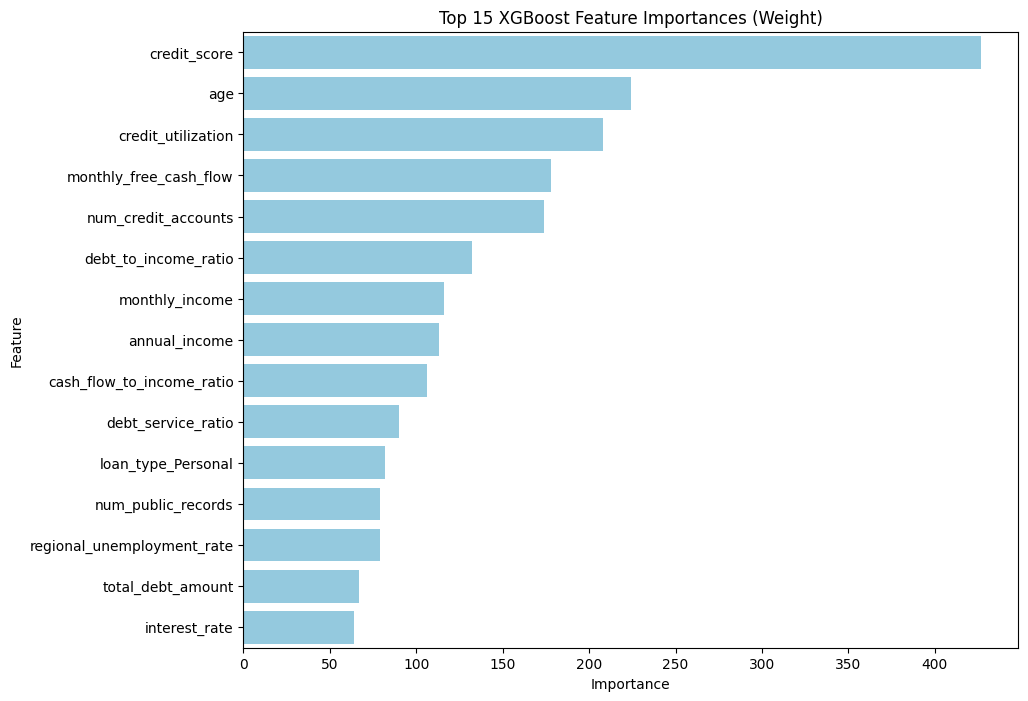

In [ ]:
importance = best_xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(
    list(importance.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

top_15_features = importance_df.head(15)

print("Top 15 Most Important Features for Default Prediction:")
print("="*50)
print(top_15_features.to_markdown(index=False))


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_features, color='skyblue')
plt.title('Top 15 XGBoost Feature Importances (Weight)')
plt.show()